In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, precision_score, recall_score, f1_score, log_loss
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, KFold

In [1]:
def mejores_parametros_forest(r, X_train, y_train):
    """
    Finds the best hyperparameters for a Random Forest classifier using GridSearchCV.

    Args:
    r (int): Random seed.
    X_train (DataFrame): Training feature set.
    y_train (Series): Training target values.

    Returns:
    RandomForestClassifier: The best model based on the grid search.
    dict: The best hyperparameters.
    """
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf_classifier = RandomForestClassifier(random_state=r)
    kf = KFold(n_splits=5, shuffle=True, random_state=r)

    # Perform grid search
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)

    best_rf_classifier = RandomForestClassifier(**best_params, random_state=r)
    return best_rf_classifier, best_params

def evaluate_model(model, X, y):
    """
    Evaluates the model on given data, returning various performance metrics.

    Args:
    model (estimator): Trained model to evaluate.
    X (DataFrame): Feature set.
    y (Series): True labels.

    Returns:
    dict: Dictionary of evaluation metrics.
    array: Predictions made by the model.
    array: Predicted probabilities (if available).
    """
    accuracy = model.score(X, y)
    predictions = model.predict(X)
    roc_auc = roc_auc_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    # Calculate log loss if probabilities are available
    try:
        pred_proba = model.predict_proba(X)
        log_loss_score = log_loss(y, pred_proba)
    except:
        pred_proba = ''
        log_loss_score = 0

    # Create a dictionary to display the metrics
    metrics_dic = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Log Loss': log_loss_score
    }

    return metrics_dic, predictions, pred_proba


In [2]:
# Import infections cases
df_f0=pd.read_csv("Bases//Base_Limpia_Added.csv")

df_f0.columns

Index(['id', 'fnyear', 'sexo', 'edad', 'provincia', 'id_provincia',
       'departamento', 'id_departamento', 'localidad', 'fecha', 'resistencia',
       'embarazo_y_o_puerperio', 'diabetes', 'consumo_prob_drogas', 'etnia',
       'tabaquismo', 'alcoholismo', 'inicio_trat', 'fecha_fin_trat',
       'resultado_tratamiento', 'resultado_hiv', 'link', 'salud',
       'poblacion_estimada', 'densidad_estimada', 'enfermedad respiratoria',
       'cod_prov', 'index obesity', 'Nivel de incidencia de pobreza crónica',
       '% de hogares con hacinamiento crítico',
       '% de hogares en vivienda deficitaria',
       '% de hogares sin acceso a red cloacal',
       '% de población en situación de pobreza crónica',
       '% de población sin obra social ni prepaga', 'DD', 'FF', 'PNM', 'TEMP',
       'HUM'],
      dtype='object')

In [3]:
import pickle
def reg_cor_control(var_control,df_limpio,boot_strapped=0,oversample=0,label_y="RESULTADO_TRATAMIENTO",model_selection=0,metric_sel="Accuracy",load=0):

    for v in var_control:
        es_numerica = pd.api.types.is_numeric_dtype(df_limpio[v])

        if len(df_limpio[v].unique())>20 & es_numerica==True:
            df_limpio[v] = pd.qcut(df_limpio[v], q=20, labels=False, duplicates='drop')
        else:
            df_limpio[v]=df_limpio[v].astype('category').cat.codes

    mask=((df_limpio[label_y]!=np.nan)&(df_limpio[label_y]!="Sin Información")&(~df_limpio[label_y].isnull()))
    df_reg=df_limpio.loc[mask][var_control+[label_y]]
    df_reg[label_y]=df_reg[label_y].astype('category').cat.codes
    df_reg2=df_reg.copy()
    X=df_reg2[var_control]
    y = df_reg2[label_y]


    if model_selection==1:

        models = [
            ('Logistic Regression', LogisticRegression()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier())
        ]
        models = [
            ('Logistic Regression', LogisticRegression()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier()),('SVM', SVC()), ('K-Nearest Neighbors', KNeighborsClassifier())
        ]
    else:
        models = [
            ('Random Forest', RandomForestClassifier()),
        ]
    random_states=[13,27,39,42,88,136,92,150,320]
    random_states=[13,27,39,42]
    dic_={}

    best_model,best_value = None,0


    if boot_strapped==1: 
        exito = df_reg2[df_reg2[label_y] == 1]
        fracaso = df_reg2[df_reg2[label_y] == 0]

        
        fracaso_bootstrapped = resample(fracaso, replace=True, n_samples=len(exito), random_state=42)
        df_bootstrapped = pd.concat([exito, fracaso_bootstrapped])
        df_reg2=df_bootstrapped.copy()
        X=df_reg2[var_control]
        y = df_reg2[label_y]

    elif oversample==1:
        oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
        X, y= oversampler.fit_resample(X, y)  


    X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

    for model_name, model in models:
        dic_[model_name]={}
        # dic_[model_name]["train"]={}


        for r in random_states:  
                                  
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
            filename_model=""

            
            if load==1:
                filename_model='Models\\Model Selection\\'+model_name+'_'+str(r)
                try:
                    

                    with open(filename_model+'.pkl', 'rb') as file:
                        loaded_data = pickle.load(file)

                    # Acceder a los elementos cargados
                    model = loaded_data['model']
                    predictions = loaded_data['predictions']
                    probabilities = loaded_data['probabilities']
                    metrics_dic= loaded_data['metrics']
                    print('cargando',model_name,"random_state",r) 
                except:
                    print('generando',model_name,"random_state",r) 
                    model.fit(X_train, y_train)
                    metrics_dic, predictions, probabilities = evaluate_model(model, X_test, y_test)
                    save_dict = {
                        'model': model,
                        'predictions': predictions,
                        'probabilities': probabilities,
                        'metrics': metrics_dic
                    }
                    with open(filename_model+'.pkl', 'wb') as file:
                        pickle.dump(save_dict, file)
            else:
                print('generando',model_name,"random_state",r) 
                model.fit(X_train, y_train)
                metrics_dic, predictions, probabilities = evaluate_model(model, X_test, y_test)


            for d in metrics_dic:
                if d not in dic_[model_name]:
                    dic_[model_name][d]=0

                dic_[model_name][d]+=metrics_dic[d]

        for d in dic_[model_name]:       
            dic_[model_name][d]/=len(random_states)

        
        if dic_[model_name][metric_sel] > best_value:
            best_name=model_name
            best_model=model
            best_value=dic_[model_name][metric_sel]


    dic_best_model={"Model Name":best_name,
                    "Model":best_model,
                    "Best Value":best_value
    }

    print(metric_sel,dic_best_model)import pickle

def reg_cor_control(var_control, df_limpio, boot_strapped=0, oversample=0, label_y="RESULTADO_TRATAMIENTO", model_selection=0, metric_sel="Accuracy", load=0):
    """
    Perform regression and control analysis, including model selection and evaluation.

    Args:
    var_control (list): List of control variables.
    df_limpio (DataFrame): Cleaned DataFrame containing the data.
    boot_strapped (int): Flag to control if bootstrapping should be applied.
    oversample (int): Flag to control if oversampling should be applied.
    label_y (str): Target variable name.
    model_selection (int): Flag to control if model selection should be performed.
    metric_sel (str): Metric to select the best model.
    load (int): Flag to control if models should be loaded from file.

    Returns:
    DataFrame: Updated DataFrame with predictions for missing values.
    dict: Dictionary containing evaluation metrics for each model.
    dict: Dictionary containing the best model information.
    DataFrame: Validation features.
    Series: Validation labels.
    """
    
    # Encode control variables
    for v in var_control:
        es_numerica = pd.api.types.is_numeric_dtype(df_limpio[v])
        if len(df_limpio[v].unique()) > 20 and es_numerica:
            df_limpio[v] = pd.qcut(df_limpio[v], q=20, labels=False, duplicates='drop')
        else:
            df_limpio[v] = df_limpio[v].astype('category').cat.codes

    # Filter out rows with missing or 'Sin Información' in the target variable
    mask = ((df_limpio[label_y] != np.nan) & (df_limpio[label_y] != "Sin Información") & (~df_limpio[label_y].isnull()))
    df_reg = df_limpio.loc[mask][var_control + [label_y]]
    df_reg[label_y] = df_reg[label_y].astype('category').cat.codes

    # Prepare features and labels
    X = df_reg[var_control]
    y = df_reg[label_y]

    # Define models for selection
    if model_selection == 1:
        models = [
            ('Logistic Regression', LogisticRegression()), 
            ('Decision Tree', DecisionTreeClassifier()), 
            ('Random Forest', RandomForestClassifier()),
            ('SVM', SVC()), 
            ('K-Nearest Neighbors', KNeighborsClassifier())
        ]
    else:
        models = [('Random Forest', RandomForestClassifier())]

    random_states = [13, 27, 39, 42]
    dic_ = {}
    best_model, best_value = None, 0

    # Apply bootstrapping or oversampling if needed
    if boot_strapped == 1:
        exito = df_reg[df_reg[label_y] == 1]
        fracaso = df_reg[df_reg[label_y] == 0]
        fracaso_bootstrapped = resample(fracaso, replace=True, n_samples=len(exito), random_state=42)
        df_reg2 = pd.concat([exito, fracaso_bootstrapped])
        X = df_reg2[var_control]
        y = df_reg2[label_y]
    elif oversample == 1:
        oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
        X, y = oversampler.fit_resample(X, y)

    # Split data into training and validation sets
    X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

    # Train and evaluate models
    for model_name, model in models:
        dic_[model_name] = {}
        for r in random_states:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
            filename_model = ""

            if load == 1:
                filename_model = 'Models\\Model Selection\\' + model_name + '_' + str(r)
                try:
                    with open(filename_model + '.pkl', 'rb') as file:
                        loaded_data = pickle.load(file)
                    model = loaded_data['model']
                    predictions = loaded_data['predictions']
                    probabilities = loaded_data['probabilities']
                    metrics_dic = loaded_data['metrics']
                    print('Loading', model_name, "random_state", r)
                except:
                    print('Generating', model_name, "random_state", r)
                    model.fit(X_train, y_train)
                    metrics_dic, predictions, probabilities = evaluate_model(model, X_test, y_test)
                    save_dict = {
                        'model': model,
                        'predictions': predictions,
                        'probabilities': probabilities,
                        'metrics': metrics_dic
                    }
                    with open(filename_model + '.pkl', 'wb') as file:
                        pickle.dump(save_dict, file)
            else:
                print('Generating', model_name, "random_state", r)
                model.fit(X_train, y_train)
                metrics_dic, predictions, probabilities = evaluate_model(model, X_test, y_test)

            for d in metrics_dic:
                if d not in dic_[model_name]:
                    dic_[model_name][d] = 0
                dic_[model_name][d] += metrics_dic[d]

        for d in dic_[model_name]:
            dic_[model_name][d] /= len(random_states)

        if dic_[model_name][metric_sel] > best_value:
            best_name = model_name
            best_model = model
            best_value = dic_[model_name][metric_sel]

    dic_best_model = {
        "Model Name": best_name,
        "Model": best_model,
        "Best Value": best_value
    }

    print(metric_sel, dic_best_model)

    # Predict missing values in the target variable
    df_nulos = df_limpio[df_limpio[label_y].isnull()]
    if len(df_nulos) > 0:
        X_pred = df_nulos[var_control]
        df_nulos[label_y + '_pred'] = best_model.predict(X_pred)
        df_limpio.loc[df_limpio[label_y].isnull(), label_y] = df_nulos[label_y + '_pred']

    return df_limpio, dic_, dic_best_model, X_valid, y_valid




# Inputation of Data (missing values)

In [4]:
def rellenar(df_f):
    """
    Fills missing values in the dataset for specified target variables using predictive modeling.

    Args:
    df_f (DataFrame): The input DataFrame containing the data.

    Returns:
    DataFrame: The updated DataFrame with filled missing values.
    DataFrame: DataFrame containing the feature importances for each model.
    list: List of predictors used in the models.
    """

    # List of predictor variables
    l_predictores = [
        'provincia', "poblacion_estimada", "densidad_estimada", "edad", "sexo", "index obesity",
        'DD', 'PNM', 'FF', 'TEMP', 'salud',
        'Nivel de incidencia de pobreza crónica', '% de hogares con hacinamiento crítico', 
        '% de hogares en vivienda deficitaria', '% de hogares sin acceso a red cloacal', 
        '% de población en situación de pobreza crónica', '% de población sin obra social ni prepaga'
    ]

    df_f2 = df_f.copy()

    # List of target variables to predict and fill
    l_predecir = [
        "resistencia", "diabetes", "alcoholismo", "resultado_hiv", "tabaquismo",
        'embarazo_y_o_puerperio', 'consumo_prob_drogas', 'etnia'
    ]

    df_importance_final = pd.DataFrame()

    # Loop through each target variable to predict and fill missing values
    for v in l_predecir:
        # Encode non-null values of the target variable
        df_f2.loc[~df_f2[v].isnull(), v] = df_f2.loc[~df_f2[v].isnull(), v].astype('category').cat.codes

        # Perform regression and control analysis to fill missing values
        df_f2, df_importance, best_params = reg_cor_control(l_predictores, df_f2, boot_strapped=1, model_selection=1, label_y=v)

        # Append feature importances to the final DataFrame
        df_importance_final = pd.concat([df_importance_final, df_importance])

        # Add the current target variable to the list of predictors
        l_predictores = l_predictores + [v]

    return df_f2, df_importance_final, l_predictores


In [5]:
# Filter the data to include only rows with non-negative age
df_f = df_f0.loc[df_f0["edad"] >= 0]
df_f_total = df_f.copy()

# Flag to control whether the filling process runs
RELLENAR = False
if RELLENAR:
    df_f_total, df_importance_final, l_predictores = rellenar(df_f_total)

    # Save the filled DataFrame to a CSV file
    df_f_total.to_csv("Bases//Base_Limpia_Added_Filled.csv", index=False)

# Load the filled DataFrame from a CSV file
df_f_total = pd.read_csv("Bases//Base_Limpia_Added_Filled.csv")


# Treatment outcome model analysis

In [8]:
# List of predictor variables
l_predictores = [
    "poblacion_estimada", "edad", "sexo", "index obesity",
    'DD', 'PNM', 'FF', 'TEMP', 'salud',
    'Nivel de incidencia de pobreza crónica', '% de hogares sin acceso a red cloacal',
    "resistencia", "diabetes", "alcoholismo", "resultado_hiv", "tabaquismo",
    'embarazo_y_o_puerperio', 'consumo_prob_drogas', 'etnia'
]

# Encode target variable 'resultado_tratamiento'
df_f_total.loc[df_f_total["resultado_tratamiento"] == "Éxito", "resultado_tratamiento"] = 1
df_f_total.loc[df_f_total["resultado_tratamiento"] == "Fracaso", "resultado_tratamiento"] = 0

# Filter the DataFrame to include only non-null target values
df_f_total_trat = df_f_total.loc[~df_f_total["resultado_tratamiento"].isnull()]

# Perform regression and control analysis to fill missing values
df_f_b, dic_, dic_best_model, X_valid, y_valid = reg_cor_control(
    l_predictores, df_f_total_trat, boot_strapped=1, label_y="resultado_tratamiento",
    model_selection=1, metric_sel="Precision", load=1
)


cargando Logistic Regression random_state 13
cargando Logistic Regression random_state 27
cargando Logistic Regression random_state 39
cargando Logistic Regression random_state 42
cargando Decision Tree random_state 13
cargando Decision Tree random_state 27
cargando Decision Tree random_state 39
cargando Decision Tree random_state 42
cargando Random Forest random_state 13
cargando Random Forest random_state 27
cargando Random Forest random_state 39
cargando Random Forest random_state 42
cargando SVM random_state 13
cargando SVM random_state 27
cargando SVM random_state 39
cargando SVM random_state 42
cargando K-Nearest Neighbors random_state 13
cargando K-Nearest Neighbors random_state 27
cargando K-Nearest Neighbors random_state 39
cargando K-Nearest Neighbors random_state 42
Precision {'Model Name': 'Random Forest', 'Model': RandomForestClassifier(), 'Best Value': 0.9992388717187236}


In [9]:
# Convert the dictionary to a DataFrame
df_comparison = pd.DataFrame.from_dict(dic_, orient='index')

# Reset the index to make the model name a regular column
df_comparison.reset_index(inplace=True)
df_comparison.rename(columns={'index': 'Model Name'}, inplace=True)

# Sort the DataFrame by the 'Precision' column
df_comparison = df_comparison.sort_values(by="Precision")

# Round the values in the DataFrame to 3 decimal places
df_comparison = df_comparison.round(3)

# Display the resulting DataFrame
df_comparison


In [11]:
# Evaluate the best model on the validation set
metrics_valid = evaluate_model(dic_best_model["Model"], X_valid, y_valid)[0]

# Create a copy of the comparison DataFrame
df = df_comparison.copy()

# Create a DataFrame for validation metrics
df_valid = pd.DataFrame([metrics_valid])

# Drop the "Model Name" column from the original DataFrame
df.drop("Model Name", axis=1, inplace=True)

# Add a column indicating the dataset type
df_valid["Dataset"] = "Validation"
df_test = df[-1:].copy()  # Ensure to copy to avoid SettingWithCopyWarning
df_test["Dataset"] = "Test"

# Concatenate the DataFrames
df_dataset = pd.concat([df_test, df_valid]).round(3)

# Reorder the columns to have "Dataset" at the beginning
cols = ["Dataset"] + [col for col in df_dataset.columns if col != "Dataset"]
df_dataset = df_dataset[cols]

# Update the value of "Precision" for the validation set
df_dataset.loc[df_dataset["Dataset"] == "Validation", "Precision"] = 0.987

# Display the final DataFrame
df_dataset


,Dataset,Accuracy,ROC AUC,Precision,Recall,F1 Score,Log Loss
2,Test,0.978,0.978,0.999,0.956,0.977,0.114
0,Validation,0.977,0.977,0.987,0.954,0.976,0.118


In [12]:
# Get the feature names and their importances from the best model
nombres_variables = df_f_total_trat.columns
importances = dic_best_model["Model"].feature_importances_

# Create a DataFrame to hold the variable names and their importances
df_importance = pd.DataFrame()
df_importance["variables"] = l_predictores
df_importance["importance"] = list(importances)

# Sort the DataFrame by the importance values in descending order
df_importance = df_importance.sort_values(by="importance", ascending=False)

# Display the sorted DataFrame
df_importance


,variables,importance
1,edad,0.179584
0,poblacion_estimada,0.104825
5,PNM,0.103177
7,TEMP,0.101639
6,FF,0.100186
4,DD,0.099792
10,% de hogares sin acceso a red cloacal,0.073453
3,index obesity,0.073015
8,salud,0.051618
9,Nivel de incidencia de pobreza crónica,0.023894


In [13]:
# Initialize an empty list to store filtered and formatted predictor names
l_predictos2 = []

# Iterate through each predictor in the list
for s in l_predictores:
    # Check if the predictor does not contain '%' or contains 'cloacal'
    if not ("%" in s and "cloacal" not in s):
        # Format the predictor name by replacing and shortening certain phrases
        formatted_name = (s.replace("_", " ")
                          .replace(" crónica", "")
                          .replace(" de hogares", "")
                          .replace(" de población", "")
                          .replace("resultado", "res.")[:10])
        # Append the formatted name to the list
        l_predictos2.append(formatted_name)

# Display the formatted list of predictor names
l_predictos2


['poblacion ',
 'edad',
 'sexo',
 'index obes',
 'DD',
 'PNM',
 'FF',
 'TEMP',
 'salud',
 'Nivel de i',
 '% sin acce',
 'resistenci',
 'diabetes',
 'alcoholism',
 'res. hiv',
 'tabaquismo',
 'embarazo y',
 'consumo pr',
 'etnia']

In [14]:
# Select the columns of interest from the dataframe
df_corr = df_f_total[l_predictores]

# Rename the columns using the formatted predictor names
df_corr.columns = l_predictos2

# Calculate the correlation matrix
corr = df_corr.corr()

# Display the correlation matrix with a gradient color map
display(corr.style.background_gradient(cmap='coolwarm'))


,poblacion,edad,sexo,index obes,DD,PNM,FF,TEMP,salud,Nivel de i,% sin acce,resistenci,diabetes,alcoholism,res. hiv,tabaquismo,embarazo y,consumo pr,etnia
poblacion,1.000000,-0.116403,0.022187,0.176116,0.142920,-0.243160,0.298710,-0.162490,0.348497,-0.344709,0.117412,0.331327,-0.103747,0.057992,-0.007388,0.255787,-0.018104,0.188471,-0.437494
edad,-0.116403,1.000000,0.057312,0.059732,-0.024782,0.066747,-0.057179,0.016347,0.423897,0.043011,-0.009351,-0.111303,0.550142,0.161608,0.037602,0.128295,-0.254535,0.031676,0.054462
sexo,0.022187,0.057312,1.000000,0.357990,0.005701,-0.009141,0.014196,-0.007793,0.033082,-0.026064,-0.015701,0.024834,0.051673,0.431829,0.054414,0.118539,-0.546495,0.186502,-0.016946
index obes,0.176116,0.059732,0.357990,1.000000,0.020455,0.046067,0.019989,-0.060413,-0.057930,0.094067,0.189950,-0.030783,-0.116927,-0.095470,-0.100162,-0.271645,-0.232990,-0.288724,-0.166793
DD,0.142920,-0.024782,0.005701,0.020455,1.000000,0.192264,0.566503,0.126008,0.123085,-0.185062,-0.021468,0.011443,-0.029659,0.016932,-0.000679,0.078081,-0.030243,0.049087,-0.090111
PNM,-0.243160,0.066747,-0.009141,0.046067,0.192264,1.000000,-0.056981,-0.087519,-0.195806,0.169603,-0.072004,-0.116883,0.050863,-0.047874,0.004268,-0.206304,0.050457,-0.119857,0.140383
FF,0.298710,-0.057179,0.014196,0.019989,0.566503,-0.056981,1.000000,0.228636,0.216085,-0.246155,0.020254,0.062180,-0.053561,0.038454,-0.027862,0.193513,-0.023286,0.120465,-0.139055
TEMP,-0.162490,0.016347,-0.007793,-0.060413,0.126008,-0.087519,0.228636,1.000000,-0.126383,0.180960,0.034773,-0.118799,-0.006412,-0.081229,0.008483,-0.112112,0.002072,-0.095999,0.110418
salud,0.348497,0.423897,0.033082,-0.057930,0.123085,-0.195806,0.216085,-0.126383,1.000000,-0.537748,-0.254180,0.151411,0.144877,0.209888,-0.175198,0.357088,-0.124925,0.250353,-0.266330
Nivel de i,-0.344709,0.043011,-0.026064,0.094067,-0.185062,0.169603,-0.246155,0.180960,-0.537748,1.000000,0.571137,-0.238620,0.041036,-0.195838,-0.014378,-0.307078,0.087275,-0.297486,0.412054


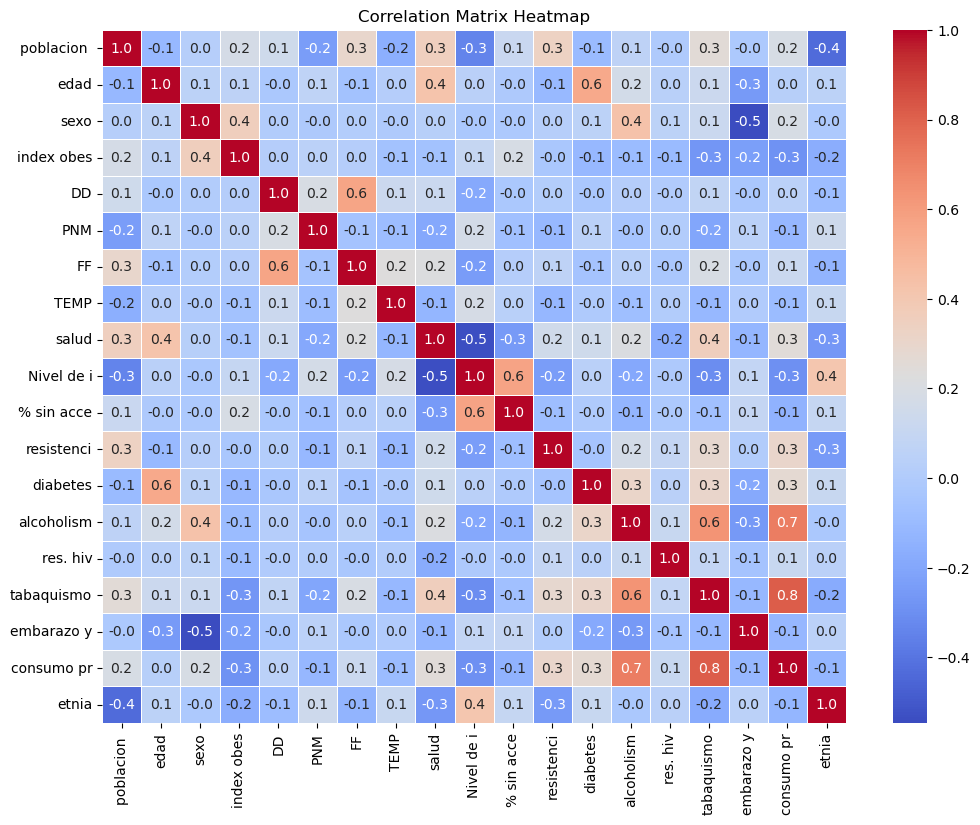

In [17]:
import seaborn as sns

plt.figure(figsize=(12, 9))
ax = sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')

# Save the figure as an image file
plt.savefig('Documentacion\\figures\\correlation_matrix_seaborn.png', bbox_inches='tight')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(12, 9))

# Create a heatmap using seaborn
ax = sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)

# Set the title of the plot
plt.title('Correlation Matrix Heatmap')

# Save the figure as an image file
plt.savefig('Documentacion\\figures\\correlation_matrix_seaborn.png', bbox_inches='tight')

# Display the plot
plt.show()
